<div class="alert alert-success">
<h1>SETUP</h1>
</div>

## Import libraries

In [1]:
import pandas as pd
import numpy as np
import os
import re
from sklearn import metrics

## Setup input

In [2]:
def setup_input():

    colnames = ['user', 'user_id', 'tweet_id', 'text', 'hashtags',
                'tweet_date', 'user_start', 'followers_count',
                'friends', 'total_tweets', 'location', 'timezone',
                'user_tweet_id', 'sarcasm', 'sarcastic', 'irony',
                'ironic', 'happy', 'sad', 'seriously']
    
    dtypes_file = {'user':str, 'user_id':str, 'tweet_id':str, 'text':str, 'hashtags':str,
                'tweet_date':str, 'user_start':str, 'followers_count':str,
                'friends':str, 'total_tweets':str, 'location':str, 'timezone':str,
                'user_tweet_id':str, 'sarcasm':str, 'sarcastic':str, 'irony':str,
                'ironic':str, 'happy':str, 'sad':str, 'seriously':str}
    
    return colnames, dtypes_file

## Setup input

In [3]:
def setup_input2():
    
    colnames = ['user_tweet_id', 'user', 'user_id', 'tweet_id', 'text',
                'hashtags', 'tweet_date', 'user_start', 'followers_count',
                'friends', 'total_tweets', 'location', 'timezone',
                'sarcasm', 'sarcastic', 'irony', 'ironic', 'happy',
                'sad', 'seriously', 'num_ht']

    dtypes_file = {'user_tweet_id':str, 'user':str, 'user_id':str, 'tweet_id':str, 'text':str,
                   'hashtags':str, 'tweet_date':str, 'user_start':str, 'followers_count':str,
                   'friends':str, 'total_tweets':str, 'location':str, 'timezone':str,
                   'sarcasm':str, 'sarcastic':str, 'irony':str, 'ironic':str, 'happy':str,
                   'sad':str, 'seriously':str, 'num_ht': str}
    
    return colnames, dtypes_file

## Read in raw data

In [4]:
def get_input(path, num_files, hashtags):
    
    get_time('Start time: ')
    
    df = pd.DataFrame()
    num_file = 0
    
    # Set up for getting input
    colnames, dtypes_file = setup_input()

    # Calculate and print total number of folders and files
    _, files = get_num_folders_files(path)

    # iterate through files (containing tweets) in folder:
    for i in next(os.walk(path))[2]:

        if not i.startswith('hashtag'):
            continue

        num_file += 1
        
        if num_file >= num_files:
            break

        print_str = 'Importing file: ' + str(i) + ' (#' + str(num_file) + ' of ' + str(files) + '), time: '
        get_time(print_str)

        fullpath = os.path.join(str(path), str(i))
        
        df_temp = pd.read_csv(filepath_or_buffer = fullpath, sep = '\t',
                                  names=colnames, error_bad_lines=True,
                                  dtype=dtypes_file, encoding='utf-8')
        
        # clean file
        df_temp = clean_file(df_temp, hashtags)

        # if first csv in group, save as df:   
        if num_file == 1:
            df = df_temp
        else:
            df = df.append(df_temp)
                
    get_time('\nDone! End time: ')
    
    return df

## Read in dataframes

In [5]:
def read_in_dfs(df_list, hashtags):
    
    colnames, dtypes_file = setup_input2()
    
    dict_dfs = {}

    for i in range(0, len(df_list)):

        key = df_list[i]
        path = './hashtag_dfs/' + df_list[i] + '.txt'
        df = pd.read_csv(filepath_or_buffer = path, sep = '\t',
                         names = colnames, error_bad_lines = True,
                         dtype=dtypes_file, encoding = 'utf-8')
        
        df = clean_file(df, hashtags)
        
        value = df
        dict_dfs[key] = value 
        
        print('Dataframe ' + df_list[i] + ' loaded, length = {:,}.'.format(len(df)))

    return dict_dfs

## Clean file

In [6]:
def clean_file(df, hashtags):
    
    # Remove first row (duplicate with column names)
    df = df.iloc[1:]
    
    # Convert numeric columns to integers:
    pd.to_numeric(df['followers_count'], errors='coerce')
    pd.to_numeric(df['friends'], errors='coerce')
    pd.to_numeric(df['total_tweets'], errors='coerce')
    
    df['followers_count'] = df['followers_count'].astype(int)
    df['friends'] = df['friends'].astype(int)
    df['total_tweets'] = df['total_tweets'].astype(int)
    
    for ht in hashtags:
        pd.to_numeric(df[ht], errors ='coerce')
        df[ht] = df[ht].astype(int)
        
    return df

## Get number of folders and files

In [7]:
def get_num_folders_files(path):
    
    folders = 0
    files = 0

    for _, dirnames, filenames in os.walk(path):
        folders += len(dirnames)
        files += len(filenames)
    
    print('\nThere are {:,} total folders and {:,} total files.'.format(folders, files))
    
    return folders, files

## Get time

In [8]:
import datetime

def get_time(print_string):

    now = datetime.datetime.now()
    hour=int(now.hour)
    minute=int(now.minute)
    second=int(now.second)
    
    if(len(str(abs(minute)))) == 1:
        minute_str = "0" + str(minute)
    else:
        minute_str = str(minute)    
    
    if print_string != "":
        print(print_string + str(hour) + ":" + str(minute_str) + ":" + str(second))
    else:
        return hour, minute_str, second

<div class="alert alert-success">
<h1>DATA CLEANING</h1>
</div>

## Clean data
Drop rows with missing tweet text and report total number of tweets and users

In [9]:
def clean_data(df):
    
    # drop rows with missing tweet text
    df = df[~df.text.isnull()]
    
    # if index hasn't been set already
    if df.index.name == None:
        # remove duplicate tweets
        df = df.drop_duplicates(subset='user_tweet_id', keep = 'first')
        # set index to 'user_tweet_id' column
        df = df.set_index(['user_tweet_id'])
    
    # encode tweet text as utf-8
    col_text = df.columns.get_loc('text')
    for i in range(0,len(df)):
        df.iloc[i,col_text].encode('utf-8')

    return df

## Count total hashtags

In [10]:
def count_total_ht(df):
    
    df['num_ht'] = 0
    df['num_ht'][df['hashtags'] != '[]'] = df.hashtags.str.count(',')+1

    return df

<div class="alert alert-success">
<h1>EXPLORATORY DATA ANALYSIS</h1>
</div>

## Get summary stats by hashtag

In [11]:
def get_stats(df, ht):
    
    from scipy import stats
    
    df = df.drop_duplicates(subset = 'user', keep = 'first')
    
    print('\nSUMMARY STATS FOR "{}" HASHTAG'.format(ht.upper()))
    
    cols = ['followers_count', 'friends', 'total_tweets']
    
    print('\n\tTotal users: {:,}'.format(df.user.unique().size))
    
    for i in cols:
        
        col = df[i]
    
        print('\n\t{}'.format(i.upper()),
              '\n\tMean: {:,.1f}'.format(np.mean(col)),
              '\n\tMedian: {:,.1f}'.format(np.median(col)),
              '\n\tSD: {:,.1f}'.format(np.std(col)),
              '\n\tSEM: {:,.1f}'.format(stats.sem(col)),
              '\n\tRange: {:,.1f} to {:,.1f}'.format(col.min(), col.max()))

## Calculate number of hashtag uses
Given a dataframe and a hashtag as input, calculate and display the number of users that used the hashtag

In [12]:
def calc_num_ht_uses(df, ht):
    
    # calculate number of tweets each user made
    df_counts = df.groupby('user').sum() 
    
    print("\n\tNumber of users that used '" + str(ht) + "' hashtag X times:")

    for i in range(1,6,1):
        ct = len(df_counts[(df_counts[ht] == i)])
        print('\tX = ' + str(i) + ' time(s): {:,}'.format(ct))

    print("\n\tNumber of users that used '" + str(ht) + "' hashtag more than X times:")

    ct = len(df_counts[(df_counts[ht] > 5)])
    print('\tX > ' + str(5) + ' times: {:,}'.format(ct))

## Make histogram

In [13]:
def make_hist(df, col, num_grps, xlabel, ylabel, title, filename):
    
    # convert column to string
    df[col] = df[col].astype(str)

    # remove missing values
    df = df[df[col] != 'nan']

    df[col].value_counts()[0:num_grps].plot(kind = 'bar')
    plt.xlabel(xlabel)
    plt.xticks(rotation=0)
    plt.ylabel(ylabel)
    plt.title(title + '\n')
    plt.xticks(rotation=90)
    
    # Get current size
    fig_size = plt.rcParams["figure.figsize"]    
    fig_size[0] = 5
    fig_size[1] = 3
    plt.rcParams["figure.figsize"] = fig_size
    
    if filename != '':
        filepath = './graphs/' + filename + '.png'
        plt.savefig(filepath, bbox_inches='tight')

## Run linear model
Given a dataframe, a y column, a set of X columns, and a grouping column, perform an ANOVA to determine whether the groups are significantly different

In [50]:
def run_lm(df, y, X_cols, inter, aov):
    
    import statsmodels.api as sm
    from statsmodels.formula.api import ols
    from statsmodels.regression.linear_model import RegressionResults
        
    formula = y + ' ~ '
    
    for i in range(0,len(X_cols)):
        if i == len(X_cols) - 1:
            formula = formula + X_cols[i]
        else:
            if inter == True:
                formula = formula + X_cols[i] + ' * '
            else:
                formula = formula + X_cols[i] + ' + '
        
    m = ols(formula, df).fit()
    aov_table = sm.stats.anova_lm(m, typ=2)
    
    if aov == True:
        print(aov_table)
    else:
        print(m.summary())
    
    return m

## Perform Tukey's multiple comparisons test

In [52]:
def run_multcomp(df, y_col, grp_col):
    
    from statsmodels.stats.multicomp import pairwise_tukeyhsd
    from statsmodels.stats.multicomp import MultiComparison

    mc = MultiComparison(df[y_col], df[grp_col])
    result = mc.tukeyhsd()

    print(result)
    print(mc.groupsunique)

<div class="alert alert-success">
<h1>TEST-TRAIN SPLIT</h1>
</div>

In [14]:
from sklearn.cross_validation import train_test_split

def create_train_test(df, filename_base):
    
    tt_exist = False

    # set file names
    mask_file = './training_test_sets/mask_' + filename_base + '.txt'
    
    """If training and test sets exist, load them; otherwise, create them"""
    if os.path.isfile(mask_file):
        
        tt_exist = True
        
        print('\nTraining and test set files already exist, opening now.')
        
        print('Reading in mask from ' + mask_file)
        mask = np.loadtxt(mask_file, delimiter = '\t')
        print('\nLength of mask: {:,}'.format(len(mask)))
        #mask = mask[1:] # remove header row
        
        mask = mask.astype(bool)
        
        train_data = df[~mask]
        test_data = df[mask]

    else: 

        print('\nTraining and test set files do not exist, generating now.')

        # create training and test sets
        # in below, itest is an array containing the row numbers of the test set (which is 30% of the overall dataset)
        _, itest = train_test_split(range(df.shape[0]), train_size = 0.7)
        mask = np.zeros(df.shape[0], dtype=np.bool)
        mask[itest] = True

        train_data = df[~mask]
        test_data = df[mask]
            
        print('Saving mask to ' + mask_file)
        np.savetxt(fname = mask_file, X = mask, delimiter = '\t')
        
    print('Length of test: {:,}'.format(len(test_data)))
    print('Length of train: {:,}'.format(len(train_data)))
    print('Length of test + train: {:,}'.format(len(test_data) + len(train_data)))

    return train_data, test_data, mask

/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


<div class="alert alert-success">
<h1>MODELING</h1>
</div>

## Determine most frequent words

In [15]:
def freq_words(num_words, cv, X, top):

    words = np.array(cv.get_feature_names())

    # calculate word frequencies
    freq = np.asarray(X.sum(axis=0)).ravel()

    # sort rows by frequencies (low to high) and return indices:
    ind = np.argsort(freq)
    
    if top == True:
        # freq_words = words with highest probability
        # below, freq_words represents N words from end (highest freqs)
        freq_words = words[ind[-num_words:]]
        freq_num = freq[ind[-num_words:]]
        
        print('Most frequent words\n')
        for w, p in zip(freq_words, freq_num):
            print('{:>10,.2f}'.format(p), '{:>10}'.format(w))
    else:
        # freq_words = words with highest probability
        freq_words = words[ind[:num_words]]
        freq_num = freq[ind[:num_words]]
        print('Least frequent words\n')
        for w, p in zip(freq_words, freq_num):
            print('{:>10,.2f}'.format(p), '{:>10}'.format(w))    
    
    print('\nTotal # of words in vocabulary: {:,}'.format(len(words)))

## Determine most predictive words

In [16]:
def predictive_words(num_words, cv, clf, Xtest):

    words = np.array(cv.get_feature_names())
    
    # create identity matrix (each row has exactly 1 feature):
    x = np.eye(Xtest.shape[1]) 

    # use trained classifier to make predictions on this matrix:
    probs = clf.predict_log_proba(x)[:, 0] 

    # sort rows by predicted probabilities and return indices:
    ind = np.argsort(probs) 

    # good_words = words with highest probability
    good_words = words[ind[:num_words]]

    # bad_words = words with lowest probability
    bad_words = words[ind[-num_words:]]

    good_prob = probs[ind[:num_words]]
    bad_prob = probs[ind[-num_words:]]

    print('\nMost predictive words')
    print('\tP(sarcasm | word)')
    for w, p in zip(good_words, good_prob):
        print('{:>10}'.format(w), '{:>10.2f}'.format(1 - np.exp(p)))

    print('\nLeast predictive words')
    print('\tP(sarcasm | word)')
    for w, p in zip(bad_words, bad_prob):
        print('{:>10}'.format(w), '{:>10.2f}'.format(1 - np.exp(p))) 

## Model evaluation

In [17]:
from sklearn import metrics

def model_eval(clf, Xtrain, Xtest, ytrain, ytest):

    ypred_test = clf.predict(Xtest)
    ypred_train = clf.predict(Xtrain)
    ypred_proba = clf.predict_proba(Xtest)
    
    # accuracy
    acc_train = round(100*metrics.accuracy_score(ypred_train, ytrain),2)
    print('\nAccuracy for training set = {:.2f}%'.format(acc_train))

    acc_test = round(100*metrics.accuracy_score(ypred_test, ytest),2)
    print('Accuracy for test set = {:.2f}%'.format(acc_test))

    # cohen's kappa
    cohenk = metrics.cohen_kappa_score(ytest, ypred_test)
    print('Cohen\'s Kappa = {:.2f}'.format(cohenk))
    
    # precision (ability of classifier not to label as positive a sample that is negative)
    precision = metrics.precision_score(ytest, ypred_test)
    print('Precision = {:.2f}'.format(precision))
    
    # recall
    recall = metrics.recall_score(ytest, ypred_test)
    print('Recall = {:.2f}'.format(recall))

    # F1
    f1 = metrics.f1_score(ytest, ypred_test)
    print('F1 = {:.2f}'.format(f1))
    
    # AUC
    auc = metrics.roc_auc_score(ytest, ypred_proba[:,1])
    print('AUC = {:.2f}'.format(auc))
    
    # create confusion matrix
    classes = np.unique(ytest)

    cnf_matrix = metrics.confusion_matrix(ytest, ypred_test)
    np.set_printoptions(precision=2)

    tp = float(cnf_matrix[0][0])/np.sum(cnf_matrix[0])
    tn = float(cnf_matrix[1][1])/np.sum(cnf_matrix[1])
    
    print('True positive rate = {:.2f}'.format(tp))
    print('True negative rate = {:.2f}'.format(tn))

    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes, False)
    plt.show()

## Create confusion matrix

In [18]:
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

def plot_confusion_matrix(cm, classes, normalize, cmap=plt.cm.Blues):
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title = 'Confusion matrix, with normalization'
    else:
        title = 'Confusion matrix, without normalization'

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Cross-validation: Naive Bayes

In [19]:
from sklearn.model_selection import KFold

def cv_score_NB(clf, X, y, scorefunc):
    result = 0.
    nfold = 5
    
    # split data into train/test groups, 5 times
    for train, test in KFold(nfold, shuffle=True).split(X, y):

        # fit the classifier, passed is as clf
        clf.fit(X[train], y[train]) 

        # evaluate score function on held-out data
        result += scorefunc(clf, X[test], y[test])
        
    # average score
    return result / nfold

In [20]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

def perform_cv_NB(df, mask, alphas, min_dfs, max_dfs, ngrams, score_func, vect_str):    
    
    best_params = {}
    numerator = 0
    denominator = len(alphas)
    
    #Find the best value for alpha and min_df, and the best classifier
    max_score=-np.inf
    
    #mask = mask.astype(int)
    
    for alpha in alphas:
        numerator += 1
        for min_df in min_dfs:
            for max_df in max_dfs:
                for ngram in ngrams:
                    
                    if vect_str == 'count': 
                        vectorizer = CountVectorizer(min_df=min_df, max_df=max_df, stop_words = 'english',ngram_range=ngram)       
                    elif vect_str == 'tfidf':
                        vectorizer = TfidfVectorizer(min_df=min_df, max_df=max_df, stop_words = 'english',ngram_range=ngram)
                    else:
                        print('Vectorizer not found.')
                        break

                    Xthis, ythis, _ = make_xy(df, vectorizer)

                    if Xthis == None:
                        print('After pruning, no terms remain; alpha: {}, min_df: {}, max_df: {}'.
                              format(alpha, min_df, max_df))

                        continue
                    else:
                        # only use training data for cross-validation
                        Xtrainthis = Xthis[~mask]
                        ytrainthis = ythis[~mask]

                        clf = MultinomialNB(alpha = alpha)

                        score = cv_score_NB(clf, Xtrainthis, ytrainthis, score_func)

                        if score > max_score:
                            max_score = score
                            best_params['score'] = score
                            best_params['alpha'] = alpha
                            best_params['min_df'] = min_df
                            best_params['max_df'] = max_df
                            best_params['ngram'] = ngram  
                            
        print('Progress: {:.0f}%'.format(100*(numerator/denominator)))

    print('\nScore: {:.3}, alpha: {}, min_df: {}, max_df: {}, ngram: {}'.
          format(best_params['score'], best_params['alpha'], best_params['min_df'],
                 best_params['max_df'], best_params['ngram']))
    
    return best_params, clf

## Cross-validation with GridSearch

In [21]:
from sklearn.model_selection import GridSearchCV

def cv_optimize(clf, dict_params, Xtrain, ytrain, scorer, n_folds):

    gs = GridSearchCV(clf,
                      param_grid = dict_params,
                      cv = n_folds,
                      scoring = scorer) 
    
    gs.fit(Xtrain, ytrain)
    
    print('Cross validation completed.')
    print('Best parameters: ' + str(gs.best_params_))
    print('Best score: {:.2f}'.format(gs.best_score_))
    print('Scoring method used: ' + str(gs.scorer_) + ')')
    
    return gs.best_estimator_, gs.best_params_

In [22]:
from sklearn.model_selection import RandomizedSearchCV

def cv_optimize_random(clf, dict_params, Xtrain, ytrain, scorer, n_folds):
    
    rs = RandomizedSearchCV(clf,
                            param_distributions = dict_params,
                            scoring = scorer,
                            cv = n_folds,
                            n_iter=5)
    rs.fit(Xtrain, ytrain)
    
    print('Cross validation completed.')
    print('Best parameters: ' + str(rs.best_params_))
    print('Best score: {:.2f}'.format(rs.best_score_))
    print('Scoring method used: ' + str(rs.scorer_) + ')')
    
    return rs.best_estimator_, rs.best_params_

## Make term-document matrix

In [23]:
def make_xy(df, vectorizer):
    
    if vectorizer is None:
        vectorizer = CountVectorizer()
    
    # call `fit` to build the vocabulary
    try:
        vectorizer.fit(df['text'])

        # call `transform` to convert text to a bag of words
        X = vectorizer.transform(df['text'])

        # convert sarcasm column to integers
        y = (df['sarcasm'] == 1).values.astype(np.int) 

    except ValueError:
    
        X = None
        y = None
        vectorizer = None

    return X, y, vectorizer

## Graph feature importances

In [24]:
def graph_feature_import(clf, features, Xtest, y_col, prop_feats_to_show):
    
    coefs = np.std(Xtest, 0)*clf.coef_[0,0:]

    df_graph = pd.DataFrame({'Feature': features,
                             'Coefficient': coefs,
                             'Coeff_AV': abs(coefs)})

    # sort dataframe by absolute value of coefficients
    df_graph2 = df_graph.sort_values(by = 'Coeff_AV', ascending = False)

    print('\t\nStandardized coefficients for ' + str(y_col) + '\n')
    print(df_graph2)
    
    feats_to_show = int(df_graph2.shape[0]*prop_feats_to_show)

    #x = range(df_graph2.shape[0])
    x = range(feats_to_show)
    y = df_graph2['Coeff_AV'][0:feats_to_show]
    
    plt.figure(figsize=(20,5))
    plt.bar(x, y, align='center')
    plt.xticks(np.arange(min(x), max(x)+1, 1))    
    plt.xticks(x, df_graph2['Feature'], rotation='vertical')
    plt.xlabel('Feature')
    plt.ylabel('Absolute Value of Standardized Coefficient')
    title = 'Absolute Value of Standardized Coefficients for Top {} features'.format(feats_to_show)
    plt.title(title)

    plt.show()
    
    return df_graph2

<div class="alert alert-success">
<h1>DIMENSIONALITY REDUCTION (LSI)</h1>
</div>

In [25]:
def get_vocab(path, df):

    fullpath_vocab = os.path.join(path, 'vocab.txt')

    # if vocab doesn't already exist, create it:
    if not os.path.isfile(fullpath_vocab):
        print('\tVocabulary dictionary does not already exist, creating now.')

        vocab = Dictionary(df.text.str.split())

        # filter tokens that are very rare or too common from
        # the dictionary (filter_extremes) and reassign integer ids (compactify)
        vocab.filter_extremes(no_below=10, no_above=0.4)
        vocab.compactify()

        # save vocab dictionary
        vocab.save(fullpath_vocab)

        print('\tVocabulary dictionary successfully created!')
    else:
        # load the finished dictionary from disk
        vocab = Dictionary.load(fullpath_vocab)

        print('\tVocabulary dictionary successfully loaded from disk.')

    #print(vocab)
    return vocab

In [26]:
def create_bow(path, df, vocab):
    
    fullpath_bows = os.path.join(path, 'bows.mm')

    # if bows doesn't already exist, create it
    if not os.path.isfile(fullpath_bows):
        print('\tBOWs model does not already exist, creating now.')
        bows = [vocab.doc2bow(text) for text in df.text.str.split()]
        MmCorpus.serialize(fullpath_bows, bows) # store to disk, for later use
        print('\tBOWs model successfull created!')
    else:
        bows = MmCorpus(fullpath_bows)
        print('\tBOWs successfully loaded from disk.')
        
    return bows

In [27]:
def generate_LSI(path, num_topics, vocab, bows, tfidf):
    
    filename = 'lsi_' + str(num_topics) + '.lsi'
    fullpath_lsi = os.path.join(path, filename)

    # if LSI model doesn't already exist, create it
    if not os.path.isfile(fullpath_lsi):
        print('\tLSI model does not already exist, creating it now.')
        lsi = LsiModel(tfidf[bows],
                       num_topics=num_topics,
                       id2word=vocab,
                       extra_samples=100,
                       power_iters=2)
        lsi.save(fullpath_lsi)
        print('\tLSI model with {} topics successfully created!'.format(num_topics))
    else:    
        # load the finished LSI model from disk
        lsi = LsiModel.load(fullpath_lsi)
        print('\tLSI model with {} topics successfully loaded from disk.'.format(num_topics))
    
    return lsi

In [28]:
def add_LSI_to_df(path, num_topics, bows, lsi, df):
    
    filename = 'lsi_df_' + str(num_topics) + '.txt'
    fullpath_lsi_df = os.path.join(path, filename)

    # if LSI model df doesn't already exist, create it
    if not os.path.isfile(fullpath_lsi_df):
        print('\tLSI model dataframe does not already exist, creating it now.')
        tweetids = pd.Series(range(len(bows)))
        topicids = pd.Series(range(lsi.num_topics))

        # `dict()` keeps track of the columns for each topic, in case the lsi model shuffles
        # or skips topics for odd tweets
        df_lsi = pd.DataFrame([pd.Series(dict(lsi[bows[i]]), name='tweet') for i in tweetids],
                              columns=topicids,
                              index=tweetids)

        # create dictionary of sarcasm column and user_tweet_id
        dict_sar = df.set_index('user_tweet_id')['sarcasm'].to_dict()
        
        if df.index.name == None:
            df = df.set_index('user_tweet_id')

        # add 'user_tweet_id' and sarcasm label
        df_lsi['user_tweet_id'] = df.index.values
        df_lsi['sarcasm'] = df_lsi['user_tweet_id'].map(dict_sar)

        # set index to 'user_tweet_id' column
        df_lsi.set_index(['user_tweet_id'], inplace=True)

        # save LSI dataframe
        df_lsi.to_csv(fullpath_lsi_df, sep = '\t', index = True, header = True)

        print('\tLSI model dataframe created!')
    else:
        # load the LSI df from disk
        df_lsi = pd.read_csv(filepath_or_buffer = fullpath_lsi_df,
                             sep = '\t',
                             encoding='utf-8',
                             index_col='user_tweet_id')

        print('\tLSI model dataframe successfully loaded from disk.')

    return df_lsi

In [29]:
def LSI_model(df, num_topics):
    
    print('Generating/loading LSI model, please wait.')
    
    # set path to save gensim results
    path = './gensim/'
    
    # create/load vocab (dictionary of all words in tweets)
    vocab = get_vocab(path, df)
    
    # create TF-IDF model of tweets
    tfidf = TfidfModel(id2word=vocab, dictionary=vocab)
    print('\tTF-IDF model successful generated; total documents in model: {:,}'.format(tfidf.num_docs))
    
    # create/load bag of words representation of tweets
    bows = create_bow(path, df, vocab)
    
    # create LSI model with inputted number of topics
    lsi = generate_LSI(path, num_topics, vocab, bows, tfidf)
    
    # add LSI components to original dataframe
    df_lsi = add_LSI_to_df(path, num_topics, bows, lsi, df)
    
    return df_lsi, lsi, tfidf, bows, vocab

In [30]:
def explore_topic(lsi_model, topic_number, topn):
    """
    accept a user-supplied topic number and
    print out a formatted list of the top terms
    """
        
    print('{:20} {}'.format('term', 'frequency') + '\n')

    for term, frequency in lsi_model.show_topic(topic_number, topn):
        print('{:20} {:.2f}'.format(term, frequency, 2))

<div class="alert alert-success">
<h1>MAIN CODE</h1>
</div>

<div class="alert alert-warning">
<h3>Setup</h3>
</div>

In [31]:
input_path = './hashtag_tweets/'

num_files = np.inf
hashtags = ['sarcasm','sarcastic','irony','ironic','happy','sad','seriously']

"""Check whether hashtag dataframes already exist"""
df_list = ['tweets_all', 'tweets_sarcasm', 'tweets_sad', 'tweets_happy', 'tweets_seriously']

for df in df_list:
    filepath = './hashtag_dfs/' + df + '.txt'
    if not os.path.isfile(filepath):        
        dfs_exist = False
    else:
        dfs_exist = True

if dfs_exist == False:
    """if hashtag dataframes DON'T already exist, get input and create them"""
    
    print('Dataframes do not exist, creating now.')
    tweets_all = get_input(input_path, num_files, hashtags)
else:
    """if hashtag dataframes DO already exist, load them"""

    print('Dataframes already exist, loading now.')
    
    dict_dfs = read_in_dfs(df_list, hashtags)
    tweets_all = dict_dfs['tweets_all']    
    tweets_sarcasm = dict_dfs['tweets_sarcasm']    
    tweets_happy = dict_dfs['tweets_happy']    
    tweets_sad = dict_dfs['tweets_sad']    
    tweets_seriously = dict_dfs['tweets_seriously']

Dataframes already exist, loading now.


/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try u

Dataframe tweets_all loaded, length = 95,860.
Dataframe tweets_sarcasm loaded, length = 30,910.
Dataframe tweets_sad loaded, length = 40,861.
Dataframe tweets_happy loaded, length = 12,639.
Dataframe tweets_seriously loaded, length = 11,450.


In [32]:
"""If dataframes do NOT exist, create them and save them as text files"""
if dfs_exist == False:
    
    # subset data to tweets with only one hashtag
    tweets_all = count_total_ht(tweets_all)
    tweets_all = tweets_all[tweets_all.num_ht == 1]
    
    # remove duplicate tweets & drop rows with no tweet text
    tweets_all = clean_data(tweets_all)
    
    # create subset dataframes
    tweets_sarcasm = tweets_all[tweets_all.sarcasm == 1]
    tweets_happy = tweets_all[tweets_all.happy == 1]
    tweets_sad = tweets_all[tweets_all.sad == 1]
    tweets_seriously = tweets_all[tweets_all.seriously == 1]
    
    # only include tweets with hashtag at end 
    pattern = r'\bsarcasm\b$'
    tweets_sarcasm = tweets_sarcasm[(tweets_sarcasm['text'].str.contains(pattern, case=False, na=False, regex=True))]

    pattern = r'\bhappy\b$'
    tweets_happy = tweets_happy[(tweets_happy['text'].str.contains(pattern, case=False, na=False, regex=True))]

    pattern = r'\bsad\b$'
    tweets_sad = tweets_sad[(tweets_sad['text'].str.contains(pattern, case=False, na=False, regex=True))]

    pattern = r'\bseriously\b$'
    tweets_seriously = tweets_seriously[(tweets_seriously['text'].str.contains(pattern, case=False, na=False, regex=True))]
    
    # remove hashtag from tweet text
    tweets_sarcasm['text'] = tweets_sarcasm['text'].str.replace('#sarcasm', '', case=False)
    tweets_happy['text'] = tweets_happy['text'].str.replace('#happy', '', case=False)
    tweets_sad['text'] = tweets_sad['text'].str.replace('#sad', '', case=False)
    tweets_seriously['text'] = tweets_seriously['text'].str.replace('#seriously', '', case=False)
    
    # remove '(quote)' from tweet text
    tweets_sarcasm['text'] = tweets_sarcasm['text'].str.replace('(quote)', '', case=False)
    tweets_happy['text'] = tweets_happy['text'].str.replace('(quote)', '', case=False)
    tweets_sad['text'] = tweets_sad['text'].str.replace('(quote)', '', case=False)
    tweets_seriously['text'] = tweets_seriously['text'].str.replace('(quote)', '', case=False)
    
    # remove URLs from tweet text
    pattern1 = r'http\S+'
    pattern2 = r'www\S+'
    tweets_sarcasm['text'] = tweets_sarcasm['text'] .str.replace(pattern1, '')
    tweets_sarcasm['text'] = tweets_sarcasm['text'] .str.replace(pattern2, '')
    tweets_happy['text'] = tweets_happy['text'] .str.replace(pattern1, '')
    tweets_happy['text'] = tweets_happy['text'] .str.replace(pattern2, '')
    tweets_sad['text'] = tweets_sad['text'] .str.replace(pattern1, '')
    tweets_sad['text'] = tweets_sad['text'] .str.replace(pattern2, '')
    tweets_seriously['text'] = tweets_seriously['text'] .str.replace(pattern1, '')
    tweets_seriously['text'] = tweets_seriously['text'] .str.replace(pattern2, '')

    # create new dataframe containing all tweets for above hashtags only
    tweets_all = pd.concat([tweets_sarcasm, tweets_happy, tweets_sad, tweets_seriously])
    
    # save dataframes
    filename = 'tweets_all'
    filepath = './hashtag_dfs/' + filename + '.txt'

    # Save df if file doesn't exist
    tweets_all.to_csv(filepath, sep = '\t', index = True, header = True)

    filename = 'tweets_sarcasm'
    filepath = './hashtag_dfs/' + filename + '.txt'

    # Save df if file doesn't exist
    tweets_sarcasm.to_csv(filepath, sep = '\t', index = True, header = True)

    filename = 'tweets_happy'
    filepath = './hashtag_dfs/' + filename + '.txt'

    # Save df if file doesn't exist
    tweets_happy.to_csv(filepath, sep = '\t', index = True, header = True)

    filename = 'tweets_sad'
    filepath = './hashtag_dfs/' + filename + '.txt'

    # Save df if file doesn't exist
    tweets_sad.to_csv(filepath, sep = '\t', index = True, header = True)

    filename = 'tweets_seriously'
    filepath = './hashtag_dfs/' + filename + '.txt'

    # Save df if file doesn't exist
    tweets_seriously.to_csv(filepath, sep = '\t', index = True, header = True)

<div class="alert alert-warning">
<h3>Modeling: Setup</h3>
</div>

### Create/load subset dataframe
Subset dataframe contains 50% sarcastic tweets and 50% other tweets (17% each of sad, happy, and seriously tweets)

In [33]:
hashtags = ['sarcasm', 'happy', 'sad', 'seriously']
filepath = './hashtag_dfs/tweets_all_sub.txt'

"""Check whether subset hashtag dataframe already exists"""

if not os.path.isfile(filepath):
    
    """if hashtag dataframe DOESN'T already exist, create it"""
    
    print('Dataframe does not exist, creating now.')
    
    onethird_sarcasm = int(sum(tweets_all['sarcasm'])/3)

    # randomly sample rows from happy, sad, and seriously tweets
    tweets_happy_sub = tweets_happy.sample(n = onethird_sarcasm)
    tweets_sad_sub = tweets_sad.sample(n = onethird_sarcasm)
    tweets_seriously_sub = tweets_seriously.sample(n = onethird_sarcasm)

    # combine the subset dataframes
    tweets_all_sub = pd.concat([tweets_sarcasm,
                             tweets_happy_sub,
                             tweets_sad_sub,
                             tweets_seriously_sub])

    # remove blanks
    tweets_all_sub = tweets_all_sub[pd.notnull(tweets_all_sub['text'])]
    
    # save file
    tweets_all_sub.to_csv(filepath, sep = '\t', index = True, header = True)
    
else:
    """if hashtag dataframe DOES already exist, load it"""
    
    print('Dataframe already exists, loading now.')
    
    colnames, dtypes_file = setup_input2()
    
    tweets_all_sub = pd.read_csv(filepath_or_buffer = filepath, sep = '\t',
                              names = colnames, error_bad_lines = True,
                              dtype=dtypes_file, encoding = 'utf-8')

# clean file
tweets_all_sub = clean_file(tweets_all_sub, hashtags)
    
# convert tweet text to lowercase
tweets_all_sub['text'] = tweets_all_sub['text'].str.lower()

Dataframe already exists, loading now.


/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try u

### Count number of tweets and users

In [34]:
hashtags = ['sarcasm','happy','sad','seriously']

total_n = len(tweets_all_sub)
print('Total number of tweets: {:,}'.format(total_n))

for ht in hashtags:
        
    temp_df = tweets_all_sub[tweets_all_sub[ht] == 1]
    
    n_tweets = len(temp_df)
    n_users = temp_df.user.unique().size

    print('\nNumber of tweets with {} hashtag: {:,d} ({:.2f}%)'.format(ht, n_tweets, 100*(n_tweets/total_n)))
    print('Number of users with {} hashtag: {:,d}'.format(ht, n_users))

Total number of tweets: 61,301

Number of tweets with sarcasm hashtag: 30,728 (50.13%)
Number of users with sarcasm hashtag: 23,368

Number of tweets with happy hashtag: 10,040 (16.38%)
Number of users with happy hashtag: 8,314

Number of tweets with sad hashtag: 10,271 (16.76%)
Number of users with sad hashtag: 8,149

Number of tweets with seriously hashtag: 10,262 (16.74%)
Number of users with seriously hashtag: 8,215


<div class="alert alert-warning">
<h3>Modeling: Create Train and Test Sets</h3>
</div>

### Create test and training data

In [35]:
filename_base = 'sarcasm_happy_sad_seriously'
strat = True
train, test, mask = create_train_test(tweets_all_sub, filename_base)

prop_sarc = sum(train['sarcasm'])/len(train)
print('\nPercent of sarcasm in training set: {:.2f}%'.format(prop_sarc*100))

prop_sarc = sum(test['sarcasm'])/len(test)
print('Percent of sarcasm in test set: {:.2f}%'.format(prop_sarc*100))


Training and test set files already exist, opening now.
Reading in mask from ./training_test_sets/mask_sarcasm_happy_sad_seriously.txt

Length of mask: 61,301
Length of test: 18,391
Length of train: 42,910
Length of test + train: 61,301

Percent of sarcasm in training set: 50.15%
Percent of sarcasm in test set: 50.07%


<div class="alert alert-warning">
<h3>Exploratory Data Analysis</h3>
</div>

### Get stats by hashtag

In [66]:
get_stats(tweets_sarcasm, 'sarcasm')
calc_num_ht_uses(tweets_sarcasm, 'sarcasm')

get_stats(tweets_happy, 'happy')
calc_num_ht_uses(tweets_happy, 'happy')

get_stats(tweets_sad, 'sad')
calc_num_ht_uses(tweets_sad, 'sad')

get_stats(tweets_seriously, 'seriously')
calc_num_ht_uses(tweets_seriously, 'seriously')


SUMMARY STATS FOR "SARCASM" HASHTAG

	Total users: 23,509

	FOLLOWERS_COUNT 
	Mean: 868.2 
	Median: 173.0 
	SD: 35,070.6 
	SEM: 228.7 
	Range: 0.0 to 5,192,273.0

	FRIENDS 
	Mean: 629.2 
	Median: 423.0 
	SD: 1,671.0 
	SEM: 10.9 
	Range: 0.0 to 176,631.0

	TOTAL_TWEETS 
	Mean: 4,295.6 
	Median: 2,440.0 
	SD: 8,341.5 
	SEM: 54.4 
	Range: 2.0 to 446,022.0

	Number of users that used 'sarcasm' hashtag X times:
	X = 1 time(s): 19,213
	X = 2 time(s): 2,883
	X = 3 time(s): 773
	X = 4 time(s): 289
	X = 5 time(s): 159

	Number of users that used 'sarcasm' hashtag more than X times:
	X > 5 times: 192

SUMMARY STATS FOR "HAPPY" HASHTAG

	Total users: 10,149

	FOLLOWERS_COUNT 
	Mean: 812.5 
	Median: 218.0 
	SD: 10,361.0 
	SEM: 102.9 
	Range: 0.0 to 753,605.0

	FRIENDS 
	Mean: 693.7 
	Median: 433.0 
	SD: 2,478.5 
	SEM: 24.6 
	Range: 0.0 to 223,235.0

	TOTAL_TWEETS 
	Mean: 3,851.3 
	Median: 2,487.0 
	SD: 5,809.7 
	SEM: 57.7 
	Range: 1.0 to 175,701.0

	Number of users that used 'happy' hashtag X tim

### Top user locations by hashtag

In [54]:
print('\nSarcasm Hashtag:\n{}'.format(tweets_sarcasm['location'].value_counts()[0:5]))
print('\nHappy Hashtag:\n{}'.format(tweets_happy['location'].value_counts()[0:5]))
print('\nSad Hashtag:\n{}'.format(tweets_sad['location'].value_counts()[0:5]))
print('\nSeriously Hashtag:\n{}'.format(tweets_seriously['location'].value_counts()[0:5]))


Sarcasm Hashtag:
New York, NY       255
Los Angeles, CA    250
Chicago, IL        245
United States      212
Seattle, WA        172
Name: location, dtype: int64

Happy Hashtag:
Los Angeles, CA    141
New York, NY       132
London             124
Chicago, IL        119
Washington, DC      95
Name: location, dtype: int64

Sad Hashtag:
United States      624
Los Angeles, CA    373
New York, NY       352
Chicago, IL        311
Washington, DC     274
Name: location, dtype: int64

Seriously Hashtag:
Seriously?         171
Chicago, IL        126
Washington, DC     116
New York, NY       113
Los Angeles, CA    112
Name: location, dtype: int64


### Top timezones by hashtag

In [55]:
print('\nSarcasm Hashtag:\n{}'.format(tweets_sarcasm['timezone'].value_counts()[0:5]))
print('\nHappy Hashtag:\n{}'.format(tweets_happy['timezone'].value_counts()[0:5]))
print('\nSad Hashtag:\n{}'.format(tweets_sad['timezone'].value_counts()[0:5]))
print('\nSeriously Hashtag:\n{}'.format(tweets_seriously['timezone'].value_counts()[0:5]))


Sarcasm Hashtag:
Eastern Time (US & Canada)    7334
Central Time (US & Canada)    5323
Pacific Time (US & Canada)    3552
Quito                         1210
London                        1088
Name: timezone, dtype: int64

Happy Hashtag:
Eastern Time (US & Canada)    2631
Central Time (US & Canada)    1964
Pacific Time (US & Canada)    1427
London                         779
Quito                          662
Name: timezone, dtype: int64

Sad Hashtag:
Eastern Time (US & Canada)    8679
Pacific Time (US & Canada)    5107
Central Time (US & Canada)    4978
Quito                         1516
Atlantic Time (Canada)        1229
Name: timezone, dtype: int64

Seriously Hashtag:
Eastern Time (US & Canada)    2809
Central Time (US & Canada)    2329
Pacific Time (US & Canada)    1190
Quito                          678
Atlantic Time (Canada)         475
Name: timezone, dtype: int64


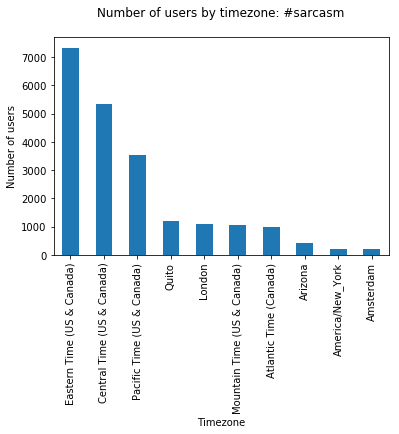

In [56]:
title = 'Number of users by timezone: #sarcasm'
xlabel = 'Timezone'
ylabel = 'Number of users'
filename = 'timezones_sarcasm'
make_hist(tweets_sarcasm, 'timezone', 10, xlabel, ylabel, title, filename)

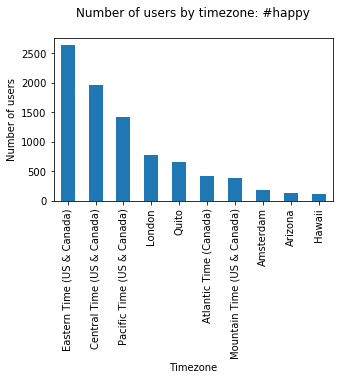

In [57]:
title = 'Number of users by timezone: #happy'
xlabel = 'Timezone'
ylabel = 'Number of users'
filename = 'timezones_happy'
make_hist(tweets_happy, 'timezone', 10, xlabel, ylabel, title, filename)

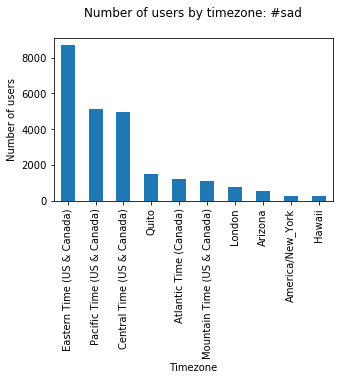

In [58]:
title = 'Number of users by timezone: #sad'
xlabel = 'Timezone'
ylabel = 'Number of users'
filename = 'timezones_sad'
make_hist(tweets_sad, 'timezone', 10, xlabel, ylabel, title, filename)

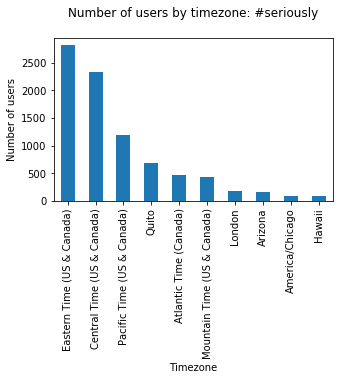

In [59]:
title = 'Number of users by timezone: #seriously'
xlabel = 'Timezone'
ylabel = 'Number of users'
filename = 'timezones_seriously'
make_hist(tweets_seriously, 'timezone', 10, xlabel, ylabel, title, filename)

### Statistically compare friends, followers, and total tweets

In [54]:
# add column to represent hashtag as string
temp_col = np.where(tweets_all['sarcasm'] == 1, 'sarcasm','')
temp_col = np.where(tweets_all['happy'] == 1, 'happy', temp_col)
temp_col = np.where(tweets_all['sad'] == 1, 'sad', temp_col)
temp_col = np.where(tweets_all['seriously'] == 1, 'seriously', temp_col)
tweets_all['ht'] = temp_col

In [55]:
cols = ['friends','followers_count','total_tweets']
for col in cols:

    line_break = '\n=====================================\n'
    print('{}ANOVA: {}{}'.format(line_break, col.upper(), line_break))
    run_lm(tweets_all, col, ['ht'], True, True)

    print('{}PAIRWISE COMPARISONS: {}{}'.format(line_break, col.upper(), line_break))
    run_multcomp(tweets_all, col, 'ht')


ANOVA: FRIENDS

                sum_sq       df          F        PR(>F)
ht        4.206106e+08      3.0  14.797238  1.252158e-09
Residual  9.082336e+11  95856.0        NaN           NaN

PAIRWISE COMPARISONS: FRIENDS

  Multiple Comparison of Means - Tukey HSD,FWER=0.05 
 group1   group2   meandiff   lower    upper   reject
-----------------------------------------------------
 happy     sad     58.8559   -21.6318 139.3436 False 
 happy   sarcasm   -65.6765 -149.1689 17.8158  False 
 happy  seriously -116.4726 -218.4993 -14.4459  True 
  sad    sarcasm  -124.5325 -184.1445 -64.9204  True 
  sad   seriously -175.3285 -258.9471 -91.7099  True 
sarcasm seriously  -50.796  -137.3106 35.7185  False 
-----------------------------------------------------
['happy' 'sad' 'sarcasm' 'seriously']

ANOVA: FOLLOWERS_COUNT

                sum_sq       df         F    PR(>F)
ht        1.608514e+09      3.0  1.059745  0.364813
Residual  4.849773e+13  95856.0       NaN       NaN

PAIRWISE COMPARISONS

<div class="alert alert-warning">
<h3>Modeling: Cross-Validation for Naive Bayes</h3>
</div>

### Perform cross-validation

#### Naive Bayes with AUC as scoring function & using CountVectorizer

In [62]:
alphas = [1, 5, 10, 15, 20]
min_dfs = [1, 2, 3, 4, 5, 10, 15, 20]
max_dfs = [.6, .7, .8, .9, 1.0]
ngrams = [(1,1), (2,2)]
score_func = metrics.make_scorer(metrics.auc) # scoring method for cv_optimize
vect_str = 'count'

print('Results for Naive Bayes model using CountVectorizer with AUC as scoring function:\n')
best_params_NB_auc_count, clf_NB_auc_count = perform_cv_NB(tweets_all_sub, mask, alphas, min_dfs, max_dfs, ngrams, score_func, vect_str)

Results for Naive Bayes model using CountVectorizer with AUC as scoring function:

Progress: 20%
Progress: 40%
Progress: 60%
Progress: 80%
Progress: 100%

Score: 1.0, alpha: 1, min_df: 10, max_df: 0.7, ngram: (2, 2)


#### Naive Bayes with AUC as scoring function & using TF-IDF Vectorizer

In [63]:
alphas = [1, 5, 10, 15, 20]
min_dfs = [1, 2, 5, 10, 15]
max_dfs = [.6, .7, .8, .9, 1.0]
ngrams = [(1,1), (2,2)]
score_func = metrics.make_scorer(metrics.auc) # options: log_likelihood, cohenk, auc
vect_str = 'tfidf'

print('Results for Naive Bayes model using TfidfVectorizer with AUC as scoring function:\n')
best_params_NB_auc_tfidf, clf_NB_auc_tfidf = perform_cv_NB(tweets_all_sub, mask, alphas, min_dfs, max_dfs, ngrams, score_func, vect_str)

Results for Naive Bayes model using TfidfVectorizer with AUC as scoring function:

Progress: 20%
Progress: 40%
Progress: 60%
Progress: 80%
Progress: 100%

Score: 1.0, alpha: 1, min_df: 15, max_df: 0.6, ngram: (2, 2)


<div class="alert alert-warning">
<h3>Modeling: Evaluation for Naive Bayes Models</h3>
</div>

### Model evaluation

MODEL EVALUATION FOR NAIVE BAYES (AUC) WITH COUNT VECTORIZER
Most frequent words

    140.00 looking forward
    145.00 sounds like
    161.00  great day
    169.00   just got
    178.00   good day
    189.00  just love
    191.00 looks like
    205.00  feel like
    222.00 good thing
    271.00   don know

Total # of words in vocabulary: 1,138
Least frequent words

     10.00 like tweet
     10.00   guess ll
     10.00 thing world
     10.00 thing love
     10.00 thing going
     10.00 doesn need
     10.00 doesn sound
     10.00 doesn understand
     10.00   news day
     10.00 thehill realdonaldtrump

Total # of words in vocabulary: 1,138

Most predictive words
	P(sarcasm | word)
love people       0.95
really glad       0.93
better better       0.93
didn coming       0.93
 just love       0.92
 good know       0.92
  good job       0.92
   oh good       0.92
 wait hear       0.91
favorite thing       0.91

Least predictive words
	P(sarcasm | word)
doesn know       0.10
just bought  

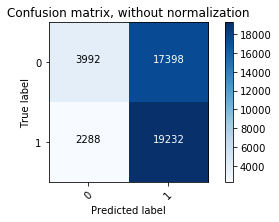

In [64]:
print('MODEL EVALUATION FOR NAIVE BAYES (AUC) WITH COUNT VECTORIZER')

best_min_df = best_params_NB_auc_count['min_df']
best_max_df = best_params_NB_auc_count['max_df']
best_alpha = best_params_NB_auc_count['alpha']
best_ngram = best_params_NB_auc_count['ngram']

vectorizer = CountVectorizer(min_df=best_min_df, max_df=best_max_df, stop_words='english', ngram_range=best_ngram)

if hasattr(vectorizer, 'stop_words_'):
    print('Number of terms ignored/excluded from model: {:,}'.format(len(vectorizer.stop_words_)))

X, y, _ = make_xy(tweets_all_sub, vectorizer)

freq_words(10, vectorizer, X, True)
freq_words(10, vectorizer, X, False)

Xtrain = X[mask]
ytrain = y[mask]
Xtest = X[~mask]
ytest = y[~mask]

clf = MultinomialNB(alpha=best_alpha).fit(Xtrain, ytrain)

predictive_words(10, vectorizer, clf, Xtest)

model_eval(clf, Xtrain, Xtest, ytrain, ytest)

MODEL EVALUATION FOR NAIVE BAYES (AUC) WITH TF-IDF VECTORIZER
Most frequent words

    122.66 looking forward
    123.66 sounds like
    128.24  great day
    135.04   good day
    142.76   just got
    147.76  just love
    159.73  feel like
    165.79 looks like
    201.75 good thing
    226.56   don know

Total # of words in vocabulary: 580
Least frequent words

     10.66 today really
     11.40   like don
     11.57  work just
     11.62  start new
     11.88 news today
     11.97 know talking
     12.05  just fine
     12.07   10 years
     12.07 night just
     12.11  like know

Total # of words in vocabulary: 580

Most predictive words
	P(sarcasm | word)
love people       0.94
didn coming       0.92
really glad       0.92
 just love       0.91
good thing       0.91
 good know       0.91
 wait hear       0.91
  good job       0.91
   oh good       0.91
favorite thing       0.91

Least predictive words
	P(sarcasm | word)
good friends       0.11
 long time       0.10
 need stop   

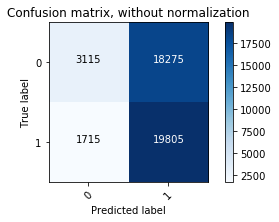

In [65]:
print('MODEL EVALUATION FOR NAIVE BAYES (AUC) WITH TF-IDF VECTORIZER')

best_min_df = best_params_NB_auc_tfidf['min_df']
best_max_df = best_params_NB_auc_tfidf['max_df']
best_alpha = best_params_NB_auc_tfidf['alpha']
best_ngram = best_params_NB_auc_tfidf['ngram']

vectorizer = TfidfVectorizer(min_df=best_min_df, max_df=best_max_df, stop_words='english', ngram_range=best_ngram)

if hasattr(vectorizer, 'stop_words_'):
    print('Number of terms ignored/excluded from model: {:,}'.format(len(vectorizer.stop_words_)))

X, y, _ = make_xy(tweets_all_sub, vectorizer)

freq_words(10, vectorizer, X, True)
freq_words(10, vectorizer, X, False)

Xtrain = X[mask]
ytrain = y[mask]
Xtest = X[~mask]
ytest = y[~mask]

clf = MultinomialNB(alpha=best_alpha).fit(Xtrain, ytrain)

predictive_words(10, vectorizer, clf, Xtest)

model_eval(clf, Xtrain, Xtest, ytrain, ytest)

<div class="alert alert-warning">
<h3>Modeling: Topic Modeling with LSI (200 Topics)</h3>
</div>

### Setup

In [66]:
from gensim.corpora import Dictionary, MmCorpus
from gensim.models import TfidfModel
from gensim.models import LsiModel
from gensim.models import LdaModel
from gensim.models.word2vec import LineSentence

In [67]:
# create subset dataframe
df = tweets_all_sub[['user_tweet_id', 'text','sarcasm']]
print('Number of tweets: {:,}'.format(len(df)))

# set path to save gensim results
path = './gensim/'

# set number of topics to use when generating LSI/LDA model
num_topics = 200

Number of tweets: 61,301


### Generate LSI model

In [68]:
# convert tweet text to lowercase
df['text'] = df['text'].str.lower()

# generate lsi with num_topics
df_lsi_200, lsi, tfidf, bows, vocab = LSI_model(df, num_topics)

/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


Generating/loading LSI model, please wait.
	Vocabulary dictionary successfully loaded from disk.
	TF-IDF model successful generated; total documents in model: 61,301
	BOWs successfully loaded from disk.
	LSI model with 200 topics successfully loaded from disk.
	LSI model dataframe successfully loaded from disk.


<div class="alert alert-warning">
<h3>Modeling: Classification with LSI Model (200 Topics)</h3>
</div>

### Setup

In [69]:
df_mod_200 = df_lsi_200.copy()
Xcols = df_mod_200.columns.values[0:num_topics]

test_data = df_mod_200[~mask]
train_data = df_mod_200[mask]

# drop rows with NaNs
test_data.dropna(how='any', inplace=True)
train_data.dropna(how='any', inplace=True)

Xtest_200 = test_data[Xcols]
ytest_200 = test_data['sarcasm']
Xtrain_200 = train_data[Xcols]
ytrain_200 = train_data['sarcasm']

/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


### Random Forest with LSI components (200)

Cross validation completed.
Best parameters: {'min_samples_split': 5, 'n_estimators': 80}
Best score: 0.90
Scoring method used: make_scorer(auc))

Accuracy for training set = 99.70%
Accuracy for test set = 62.57%
Cohen's Kappa = 0.25
Precision = 0.63
Recall = 0.60
F1 = 0.62
AUC = 0.67
True positive rate = 0.65
True negative rate = 0.60


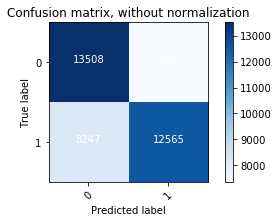

In [71]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()
dict_params = {'n_estimators': list(np.arange(10, 90, 10)),
               'min_samples_split': [2, 3, 4, 5, 6]}

scorer = metrics.make_scorer(metrics.auc) # scoring method for cv_optimize

clf_lsi_RF_200, best_params_lsi_RF = cv_optimize(clf, dict_params, Xtrain_200, ytrain_200, scorer, n_folds=5)

model_eval(clf_lsi_RF_200, Xtrain_200, Xtest_200, ytrain_200, ytest_200)

### XGB classifier with LSI components (200)

Cross validation completed.
Best parameters: {'gamma': 0.001, 'learning_rate': 0.0001, 'n_estimators': 10}
Best score: 0.90
Scoring method used: make_scorer(auc))

Accuracy for training set = 55.97%
Accuracy for test set = 54.81%
Cohen's Kappa = 0.10
Precision = 0.53
Recall = 0.88
F1 = 0.66
AUC = 0.55
True positive rate = 0.22
True negative rate = 0.88


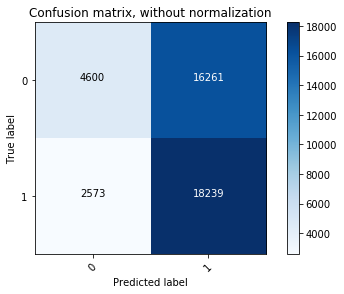

In [70]:
from xgboost import XGBClassifier

clf = XGBClassifier()
dict_params = {'learning_rate': [0.0001, 0.001, 0.01, 0.1],
               'n_estimators': list(np.arange(10, 110, 10)),
               'gamma': [.001, .01, .1, 1., 5., 10.]}

scorer = metrics.make_scorer(metrics.auc) # scoring method for cv_optimize

clf_lsi_XGB_200, best_params_lsi_XGB = cv_optimize(clf, dict_params, Xtrain_200, ytrain_200, scorer, n_folds=5)

model_eval(clf_lsi_XGB_200, Xtrain_200, Xtest_200, ytrain_200, ytest_200)

### Logistic regression with LSI components (200)

Cross validation completed.
Best parameters: {'C': 1.0, 'class_weight': 'balanced', 'fit_intercept': False}
Best score: 0.50
Scoring method used: make_scorer(auc))

Accuracy for training set = 66.95%
Accuracy for test set = 66.15%
Cohen's Kappa = 0.32
Precision = 0.67
Recall = 0.63
F1 = 0.65
AUC = 0.72
True positive rate = 0.69
True negative rate = 0.63


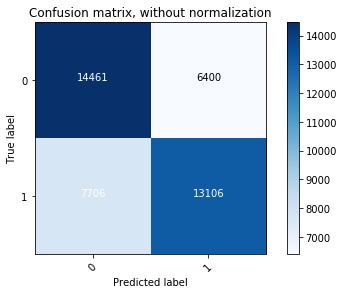

In [72]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()

# create dictionary of parameters
dict_params = {'C': [1., 2., 3.], # lower values = stronger regularization
               'class_weight': ['balanced'],
               'fit_intercept': [False]}

scorer = metrics.make_scorer(metrics.auc) # scoring method for cv_optimize

clf_lsi_LR_200, best_params_lsi_LR = cv_optimize(clf, dict_params, Xtrain_200, ytrain_200, scorer, n_folds=5)

model_eval(clf_lsi_LR_200, Xtrain_200, Xtest_200, ytrain_200, ytest_200)

<div class="alert alert-warning">
<h3>Modeling: Topic Modeling with LSI (300 Topics)</h3>
</div>

### Setup

In [38]:
from gensim.corpora import Dictionary, MmCorpus
from gensim.models import TfidfModel
from gensim.models import LsiModel
from gensim.models import LdaModel
from gensim.models.word2vec import LineSentence

In [68]:
# create subset dataframe
df = tweets_all_sub[['user_tweet_id', 'text','sarcasm']]
print('Number of tweets: {:,}'.format(len(df)))

# set path to save gensim results
path = './gensim/'

# set number of topics to use when generating LSI/LDA model
num_topics = 300

Number of tweets: 61,301


### Generate LSI model

In [69]:
# convert tweet text to lowercase
df['text'] = df['text'].str.lower()

# generate lsi with num_topics
df_lsi_300, lsi, tfidf, bows, vocab = LSI_model(df, num_topics)

/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Generating/loading LSI model, please wait.
	Vocabulary dictionary successfully loaded from disk.
	TF-IDF model successful generated; total documents in model: 61,301
	BOWs successfully loaded from disk.
	LSI model with 300 topics successfully loaded from disk.
	LSI model dataframe successfully loaded from disk.


### Setup

In [70]:
df_mod_300 = df_lsi_300.copy()
Xcols = df_mod_300.columns.values[0:num_topics]

test_data = df_mod_300[~mask]
train_data = df_mod_300[mask]

# drop rows with NaNs
test_data.dropna(how='any', inplace=True)
train_data.dropna(how='any', inplace=True)

Xtest_300 = test_data[Xcols]
ytest_300 = test_data['sarcasm']
Xtrain_300 = train_data[Xcols]
ytrain_300 = train_data['sarcasm']

/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


### Random Forest with LSI components (300)

Cross validation completed.
Best parameters: {'min_samples_split': 3, 'n_estimators': 40}
Best score: 0.70
Scoring method used: make_scorer(auc))

Accuracy for training set = 99.71%
Accuracy for test set = 60.80%
Cohen's Kappa = 0.22
Precision = 0.62
Recall = 0.57
F1 = 0.59
AUC = 0.65
True positive rate = 0.65
True negative rate = 0.57


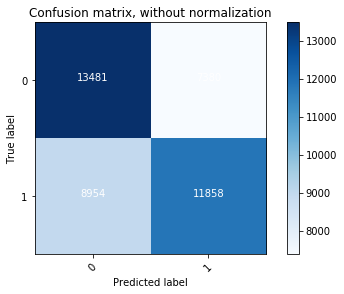

In [71]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()
dict_params = {'n_estimators': list(np.arange(10, 90, 10)),
               'min_samples_split': [2, 3, 4, 5, 6]}

scorer = metrics.make_scorer(metrics.auc) # scoring method for cv_optimize

clf_lsi_RF_300, best_params_lsi_RF = cv_optimize(clf, dict_params, Xtrain_300, ytrain_300, scorer, n_folds=5)

model_eval(clf_lsi_RF_300, Xtrain_300, Xtest_300, ytrain_300, ytest_300)

### XGB classifier with LSI components (300)

Cross validation completed.
Best parameters: {'gamma': 0.001, 'learning_rate': 0.0001, 'n_estimators': 10}
Best score: 0.90
Scoring method used: make_scorer(auc))

Accuracy for training set = 57.24%
Accuracy for test set = 55.75%
Cohen's Kappa = 0.12
Precision = 0.54
Recall = 0.72
F1 = 0.62
AUC = 0.57
True positive rate = 0.40
True negative rate = 0.72


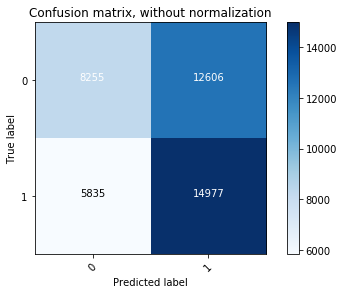

In [72]:
from xgboost import XGBClassifier

clf = XGBClassifier()
dict_params = {'learning_rate': [0.0001, 0.001, 0.01, 0.1],
               'n_estimators': list(np.arange(10, 110, 10)),
               'gamma': [.001, .01, .1, 1., 5., 10.]}

scorer = metrics.make_scorer(metrics.auc) # scoring method for cv_optimize

clf_lsi_XGB_300, best_params_lsi_XGB = cv_optimize(clf, dict_params, Xtrain_300, ytrain_300, scorer, n_folds=5)

model_eval(clf_lsi_XGB_300, Xtrain_300, Xtest_300, ytrain_300, ytest_300)

### Logistic regression with LSI components (300)

Cross validation completed.
Best parameters: {'C': 1.0, 'class_weight': 'balanced', 'fit_intercept': False}
Best score: 0.30
Scoring method used: make_scorer(auc))

Accuracy for training set = 69.13%
Accuracy for test set = 67.33%
Cohen's Kappa = 0.35
Precision = 0.68
Recall = 0.65
F1 = 0.66
AUC = 0.74
True positive rate = 0.70
True negative rate = 0.65


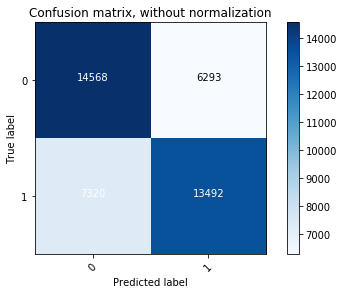

In [72]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()

# create dictionary of parameters
dict_params = {'C': [1., 2., 3.], # lower values = stronger regularization
               'class_weight': ['balanced'],
               'fit_intercept': [False]}

scorer = metrics.make_scorer(metrics.auc) # scoring method for cv_optimize

clf_lsi_LR_300, best_params_lsi_LR = cv_optimize(clf, dict_params, Xtrain_300, ytrain_300, scorer, n_folds=5)

model_eval(clf_lsi_LR_300, Xtrain_300, Xtest_300, ytrain_300, ytest_300)

<div class="alert alert-warning">
<h3>Modeling: Topic Modeling with LSI (400 Topics)</h3>
</div>

### Setup

In [39]:
# create subset dataframe
df = tweets_all_sub[['user_tweet_id', 'text','sarcasm']]
print('Number of tweets: {:,}'.format(len(df)))

# set path to save gensim results
path = './gensim/'

# set number of topics to use when generating LSI/LDA model
num_topics = 400

Number of tweets: 61,301


### Generate LSI model

In [40]:
# convert tweet text to lowercase
df['text'] = df['text'].str.lower()

# generate lsi with num_topics
df_lsi_400, lsi, tfidf, bows, vocab = LSI_model(df, num_topics)

/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Generating/loading LSI model, please wait.
	Vocabulary dictionary successfully loaded from disk.
	TF-IDF model successful generated; total documents in model: 61,301
	BOWs successfully loaded from disk.
	LSI model with 400 topics successfully loaded from disk.
	LSI model dataframe successfully loaded from disk.


### Setup

In [41]:
df_mod_400 = df_lsi_400.copy()
Xcols = df_mod_400.columns.values[0:num_topics]

test_data = df_mod_400[~mask]
train_data = df_mod_400[mask]

# drop rows with NaNs
test_data.dropna(how='any', inplace=True)
train_data.dropna(how='any', inplace=True)

Xtest_400 = test_data[Xcols]
ytest_400 = test_data['sarcasm']
Xtrain_400 = train_data[Xcols]
ytrain_400 = train_data['sarcasm']

/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


### Random Forest with LSI components (400)

Cross validation completed.
Best parameters: {'min_samples_split': 3, 'n_estimators': 50}
Best score: 0.70
Scoring method used: make_scorer(auc))

Accuracy for training set = 99.71%
Accuracy for test set = 60.78%
Cohen's Kappa = 0.22
Precision = 0.61
Recall = 0.57
F1 = 0.59
AUC = 0.65
True positive rate = 0.64
True negative rate = 0.57


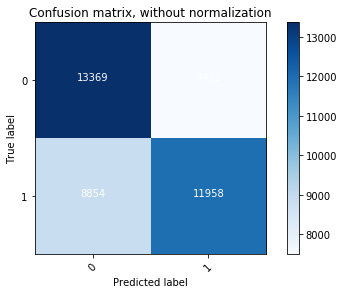

In [86]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()
dict_params = {'n_estimators': list(np.arange(10, 90, 10)),
               'min_samples_split': [2, 3, 4, 5, 6]}

scorer = metrics.make_scorer(metrics.auc) # scoring method for cv_optimize

clf_lsi_RF_400, best_params_lsi_RF = cv_optimize(clf, dict_params, Xtrain_400, ytrain_400, scorer, n_folds=5)

model_eval(clf_lsi_RF_400, Xtrain_400, Xtest_400, ytrain_400, ytest_400)

### XGB classifier with LSI components (400)

Cross validation completed.
Best parameters: {'gamma': 0.001, 'learning_rate': 0.01, 'n_estimators': 90}
Best score: 1.00
Scoring method used: make_scorer(auc))

Accuracy for training set = 59.62%
Accuracy for test set = 57.86%
Cohen's Kappa = 0.16
Precision = 0.57
Recall = 0.67
F1 = 0.61
AUC = 0.61
True positive rate = 0.49
True negative rate = 0.67


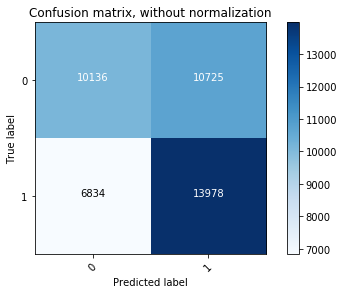

In [42]:
from xgboost import XGBClassifier

clf = XGBClassifier()
dict_params = {'learning_rate': [0.0001, 0.001, 0.01, 0.1],
               'n_estimators': list(np.arange(10, 110, 10)),
               'gamma': [.001, .01, .1, 1., 5., 10.]}

scorer = metrics.make_scorer(metrics.auc) # scoring method for cv_optimize

clf_lsi_XGB_400, best_params_lsi_XGB = cv_optimize(clf, dict_params, Xtrain_400, ytrain_400, scorer, n_folds=5)

model_eval(clf_lsi_XGB_400, Xtrain_400, Xtest_400, ytrain_400, ytest_400)

### Logistic regression with LSI components (400)

Cross validation completed.
Best parameters: {'C': 1.0, 'class_weight': 'balanced', 'fit_intercept': False}
Best score: 0.20
Scoring method used: make_scorer(auc))

Accuracy for training set = 70.04%
Accuracy for test set = 67.70%
Cohen's Kappa = 0.35
Precision = 0.68
Recall = 0.65
F1 = 0.67
AUC = 0.74
True positive rate = 0.70
True negative rate = 0.65


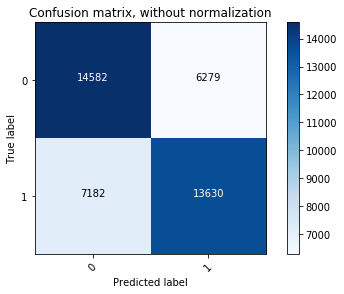

In [43]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()

# create dictionary of parameters
dict_params = {'C': [1., 2., 3.], # lower values = stronger regularization
               'class_weight': ['balanced'],
               'fit_intercept': [False]}

scorer = metrics.make_scorer(metrics.auc) # scoring method for cv_optimize

clf_lsi_LR_400, best_params_lsi_LR_400 = cv_optimize(clf, dict_params, Xtrain_400, ytrain_400, scorer, n_folds=5)

model_eval(clf_lsi_LR_400, Xtrain_400, Xtest_400, ytrain_400, ytest_400)

	
Standardized coefficients for sarcasm

     Coeff_AV  Coefficient Feature
9    0.494364    -0.494364       9
11   0.381449     0.381449      11
44   0.344495    -0.344495      44
7    0.323437    -0.323437       7
14   0.264873    -0.264873      14
33   0.257437    -0.257437      33
3    0.248882     0.248882       3
68   0.242246    -0.242246      68
32   0.240177     0.240177      32
17   0.237120    -0.237120      17
85   0.176489     0.176489      85
77   0.175069     0.175069      77
62   0.173112    -0.173112      62
24   0.170950     0.170950      24
46   0.168894    -0.168894      46
8    0.162355     0.162355       8
1    0.160901    -0.160901       1
164  0.152633     0.152633     164
0    0.148922     0.148922       0
72   0.146977     0.146977      72
73   0.139915    -0.139915      73
69   0.138572     0.138572      69
13   0.136113    -0.136113      13
4    0.135085     0.135085       4
156  0.130151     0.130151     156
216  0.128210    -0.128210     216
170  0.127725 

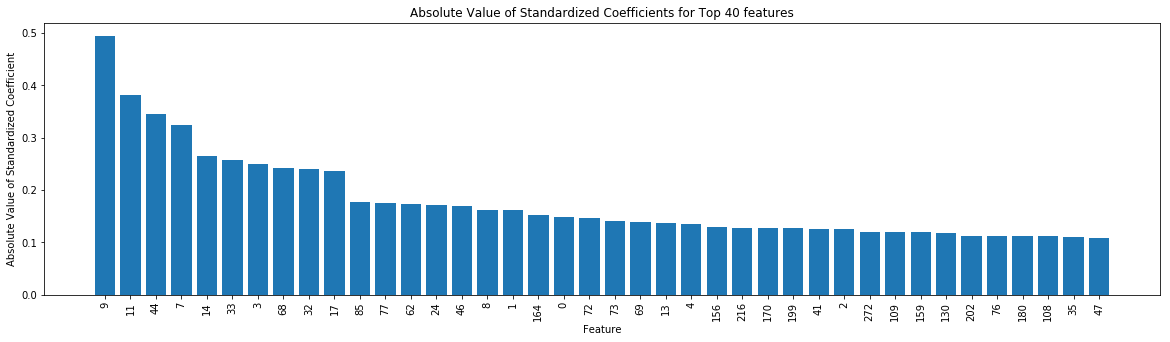

In [45]:
feature_names = Xcols
y_col = 'sarcasm'
prop_feats_to_show = .1
df_graph2 = graph_feature_import(clf_lsi_LR_400, feature_names, Xtest_400, y_col, prop_feats_to_show)

In [48]:
# explore topics with largest standardized coefficients
explore_topic(lsi, 9, 15)

term                 frequency

for                  -0.66
my                   0.39
thanks               -0.31
are                  0.21
just                 0.20
love                 -0.16
and                  0.14
was                  0.13
the                  -0.12
great                -0.12
with                 0.12
on                   0.10
that                 0.10
this                 -0.10
so                   -0.09
